In [3]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Convolutional Neural Network (CNN) with PyTorch: MNIST Dataset

This notebook demonstrates how to build, train, and evaluate a simple CNN for handwritten digit classification using the MNIST dataset. You'll learn about data loading, model definition, training, evaluation, and visualizing results.

In [4]:
# Convert MNIST dataset to PyTorch tensors of 4-Dimensions (# of images, # of channels, height, width)
transform = transforms.ToTensor()

## About the MNIST Dataset

The MNIST dataset contains 70,000 images of handwritten digits (0-9), each 28x28 pixels in grayscale. We'll use PyTorch's torchvision to load and preprocess the data. The transform converts images to PyTorch tensors.

In [5]:
# Train and test datasets
train_dataset = datasets.MNIST(root='MNIST_train_data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='MNIST_test_data', train=False, download=True, transform=transform)

100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%
100.0%


In [8]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST_train_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [9]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: MNIST_test_data
    Split: Test
    StandardTransform
Transform: ToTensor()

## Data Loading and Batching

We split the data into training and test sets and use DataLoader to efficiently batch and shuffle the data for training.

In [11]:
# Create a small batch size for images
batch_size = 10
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

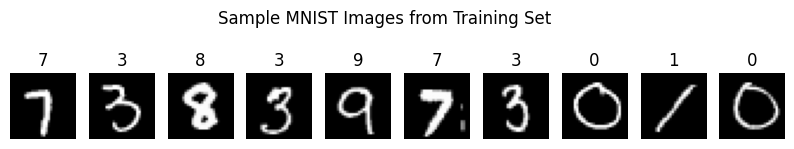

In [55]:
# Visualize a batch of sample images
examples = next(iter(train_loader))
images, labels = examples
plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(str(labels[i].item()))
    plt.axis('off')
plt.suptitle('Sample MNIST Images from Training Set')
plt.show()

In [12]:
# Define the CNN model
# Describe convolutional layers and what it's doing (2 convolutional layers)
conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)  # 1 input channel (grayscale), 6 output channels
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)  # 6 input channels, 16 output channels

In [13]:
# Grab 1 MNIST image/record
for i, (X_Train, y_Train) in enumerate(train_dataset):
    break

In [16]:
X_Train.shape  # Shape of the image tensor (1, 28, 28) - 1 channel, 28x28 pixels

torch.Size([1, 28, 28])

In [17]:
x = X_Train.view(1, 1, 28, 28)  # Reshape to (batch_size, channels, height, width)

In [19]:
# Perform our first convolution
x = F.relu(conv1(x))  # Apply ReLU activation function

In [21]:
x.shape  # Shape after first convolution (1, 6, 26, 26) - 6 channels, 26x26 pixels

torch.Size([1, 6, 26, 26])

In [22]:
# pass through pooling layer
x = F.max_pool2d(x, kernel_size=2, stride=2)

In [23]:
x.shape  # Shape after pooling (1, 6, 13, 13) - 6 channels, 13x13 pixels

torch.Size([1, 6, 13, 13])

In [24]:
# Do the second convolution
x = F.relu(conv2(x))  # Apply ReLU activation function

In [25]:
x.shape  # Shape after pooling (1, 6, 13, 13) - 6 channels, 13x13 pixels

torch.Size([1, 16, 11, 11])

In [26]:
# Pool the second convolution
x = F.max_pool2d(x, kernel_size=2, stride=2)

In [27]:
x.shape  # Shape after pooling (1, 6, 13, 13) - 6 channels, 13x13 pixels

torch.Size([1, 16, 5, 5])

## Model Architecture

We define a simple CNN with two convolutional layers followed by fully connected layers. The model takes 28x28 grayscale images and outputs probabilities for 10 digit classes (0-9).

In [28]:
# Model Class
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # 10 output classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Flatten the tensor
        x = x.view(-1, 16 * 5 * 5) # negative one means "infer batch size automatically"

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.log_softmax(x, dim=1)  # Log softmax for multi-class classification

In [57]:
# Create an instance of the model
torch.manual_seed(42)  # For reproducibility
model = CNNModel()

In [56]:
# Print model summary
print(model)

CNNModel(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Loss Function and Optimizer

We use cross-entropy loss for multi-class classification and the Adam optimizer for training the model.

In [32]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
# Note: the smaller the learning rate, the slower the model will learn

## Training the Model

We train the model for several epochs, tracking loss and accuracy on both the training and test sets. Progress is printed during training.

In [33]:
import time
start_time = time.time()

# Create Variables to track training progress
num_epochs = 5
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    train_correct = 0
    test_correct = 0

    # Training phase
    for i, (X_train, y_train) in enumerate(train_loader):

        i += 1
        y_pred = model(X_train) # get predictions, not flattened 
        loss = criterion(y_pred, y_train) # how far off are we from the correct answer

        predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions
        batch_correct = (predicted == y_train).sum() # how may we got correct from this batch
        train_correct += batch_correct # keep track of the total correct predictions

        # Update the model parameters
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the weights

        # print progress
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}, Accuracy: {100 * batch_correct / len(X_train):.2f}%')

    train_losses.append(loss)
    train_accuracies.append(train_correct)

    # Testing phase
    with torch.no_grad(): # No gradient calculation for testing
        for i, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]  # Get the predicted class
            test_correct += (predicted == y_test).sum()  # Count correct predictions

        loss = criterion(y_val, y_test)  # Calculate loss for the test set
        test_losses.append(loss)
        test_accuracies.append(test_correct)

current_time = time.time()
total_time = current_time - start_time
print(f'Training completed in {total_time:.2f} seconds')

Epoch [1/5], Step [100/6000], Loss: 1.3506, Accuracy: 60.00%
Epoch [1/5], Step [200/6000], Loss: 0.7213, Accuracy: 90.00%
Epoch [1/5], Step [300/6000], Loss: 0.1584, Accuracy: 100.00%
Epoch [1/5], Step [400/6000], Loss: 0.2831, Accuracy: 90.00%
Epoch [1/5], Step [500/6000], Loss: 0.4556, Accuracy: 90.00%
Epoch [1/5], Step [600/6000], Loss: 0.0473, Accuracy: 100.00%
Epoch [1/5], Step [700/6000], Loss: 0.0729, Accuracy: 100.00%
Epoch [1/5], Step [800/6000], Loss: 0.0470, Accuracy: 100.00%
Epoch [1/5], Step [900/6000], Loss: 0.1686, Accuracy: 90.00%
Epoch [1/5], Step [1000/6000], Loss: 0.9199, Accuracy: 90.00%
Epoch [1/5], Step [1100/6000], Loss: 0.0574, Accuracy: 100.00%
Epoch [1/5], Step [1200/6000], Loss: 0.0734, Accuracy: 100.00%
Epoch [1/5], Step [1300/6000], Loss: 0.7641, Accuracy: 80.00%
Epoch [1/5], Step [1400/6000], Loss: 0.5926, Accuracy: 80.00%
Epoch [1/5], Step [1500/6000], Loss: 0.4661, Accuracy: 80.00%
Epoch [1/5], Step [1600/6000], Loss: 0.6574, Accuracy: 80.00%
Epoch [1/5]

## Visualizing Training and Test Loss

Plotting the loss over epochs helps us see if the model is learning and if the loss is decreasing as expected.

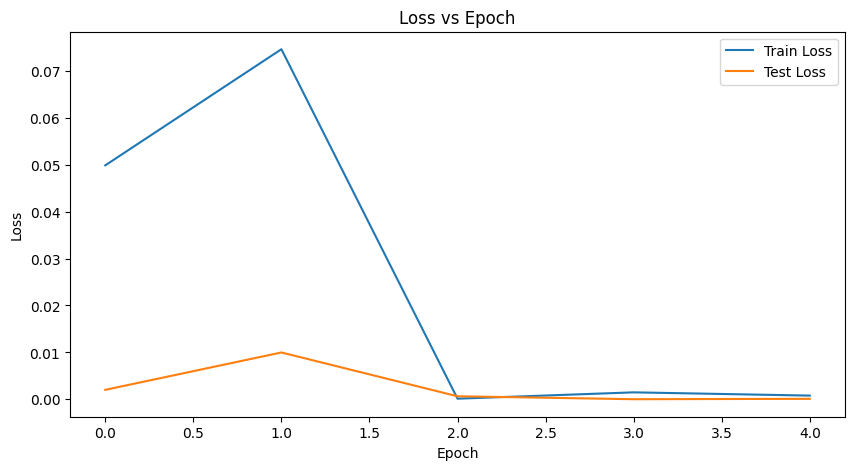

In [35]:
# Graph the loss at each epoch
train_losses = [loss.item() for loss in train_losses]
test_losses = [loss.item() for loss in test_losses]
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

## Visualizing Training and Test Accuracy

Plotting accuracy over epochs shows how well the model is learning to classify digits.

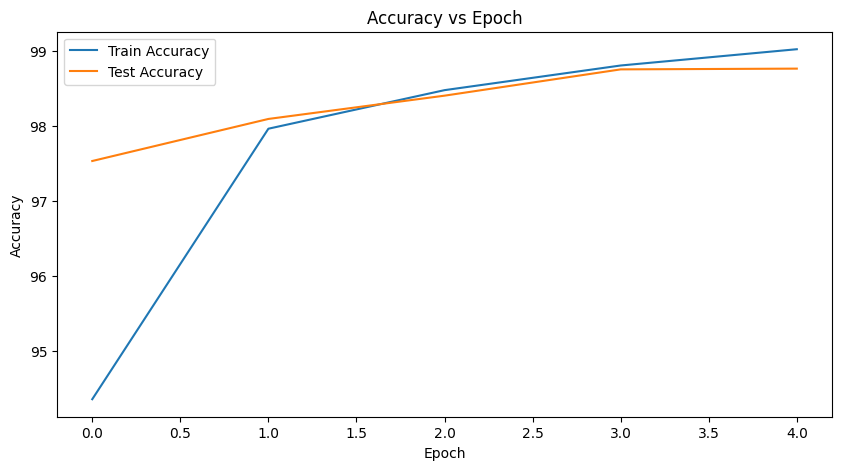

In [38]:
# Graph the accuracy at each epoch
train_accuracies = [acc/600 for acc in train_accuracies]
test_accuracies = [acc/100 for acc in test_accuracies]
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.show()

## Final Test Accuracy

After training, we evaluate the model on the entire test set to calculate the final accuracy.

In [39]:
test_load_everything = DataLoader(test_dataset, batch_size=10000, shuffle=False)

In [40]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_everything:
        y_val = model(X_test)
        predicted = torch.max(y_val.data, 1)[1]
        correct += (predicted == y_test).sum().item()  # Count correct predictions

In [46]:
# Did for correct predictions
correct/len(test_dataset)*100  # Total number of correct predictions

98.76

## Making Predictions on a Single Image

Let's grab a test image, visualize it, and see what the model predicts.

In [49]:
# Grab an image from the test dataset
test_dataset[4143] # Tensor with the image data and label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [50]:
# Grab just the image data
image_data = test_dataset[4143][0]  # Get the image tensor

In [51]:
# Reshape the image data to match the input shape of the model
image_data = image_data.view(1, 1, 28, 28)

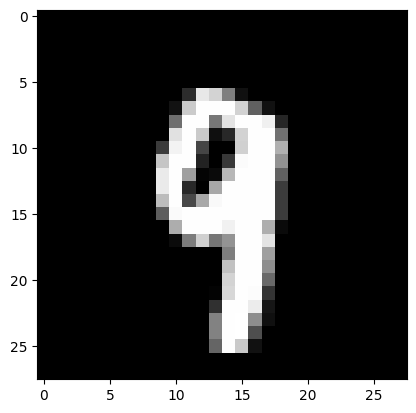

In [52]:
# Show the image
plt.imshow(image_data.squeeze(), cmap='gray')

In [53]:
# Pass the image through the model to get predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_val = model(image_data)  # Get predictions
    predicted_class = torch.max(y_val.data, 1)[1]  # Get the predicted class

In [54]:
# Check the predicted class
predicted_class.item()  # Get the predicted class as a Python integer

9

## Confusion Matrix & Classification Report

Let's print out a report of how well our data did in detail.

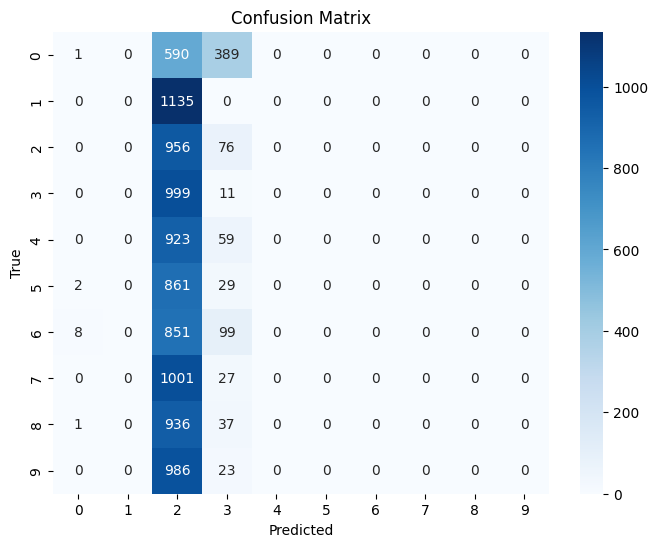

              precision    recall  f1-score   support

           0       0.08      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.10      0.93      0.19      1032
           3       0.01      0.01      0.01      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.10     10000
   macro avg       0.02      0.09      0.02     10000
weighted avg       0.02      0.10      0.02     10000



/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

In [58]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get all test predictions
all_preds = []
all_labels = []
with torch.no_grad():
    for X_test, y_test in test_loader:
        y_val = model(X_test)
        preds = torch.max(y_val.data, 1)[1]
        all_preds.extend(preds.numpy())
        all_labels.extend(y_test.numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(all_labels, all_preds))

## Plot Misclassified Images

Let's view some predictions that were incorrect and what our model thought they were.

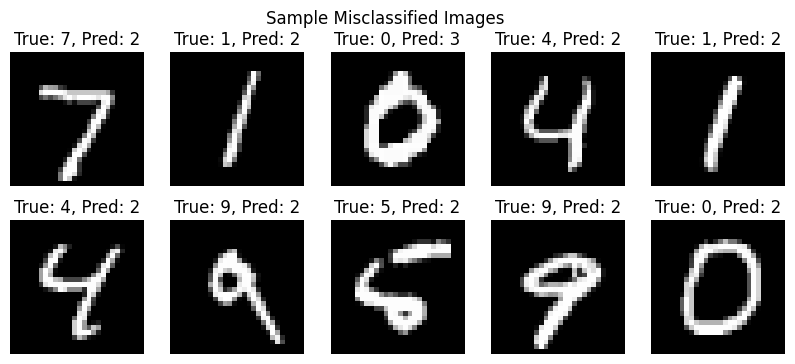

In [59]:
# Plot a few misclassified images
misclassified = [(img, pred, label) for img, pred, label in zip(test_dataset, all_preds, all_labels) if pred != label]
plt.figure(figsize=(10,4))
for i, (img, pred, label) in enumerate(misclassified[:10]):
    plt.subplot(2,5,i+1)
    plt.imshow(img[0].squeeze(), cmap='gray')
    plt.title(f'True: {label}, Pred: {pred}')
    plt.axis('off')
plt.suptitle('Sample Misclassified Images')
plt.show()

# Summary

- Built and trained a CNN for handwritten digit classification using PyTorch and MNIST.
- Visualized data, model performance, and misclassifications.
- Next steps: try more epochs, experiment with data augmentation, or use a deeper network for better accuracy!